In [7]:
# JAX-based Slime Mold Foraging Simulation (Stage 1)

import jax
import jax.numpy as jnp
from jax import random, lax
import numpy as np
from noise_custom import Perlin, perlin_multi_octave
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial import cKDTree

from ipyleaflet import Map, Marker, basemaps, GeoJSON, FullScreenControl, DivIcon, Polyline, CircleMarker
import pandas as pd
import json
from PIL import Image
import networkx as nx

In [130]:
# Load the grid from output.json
def load_grid_from_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return jnp.array(data)

map_with_stations = load_grid_from_json('distance-calculations/output.json')
# flip the map to be in x,y coordinates
map_with_stations = jnp.flipud(map_with_stations)
map_with_stations = jnp.array(map_with_stations).T

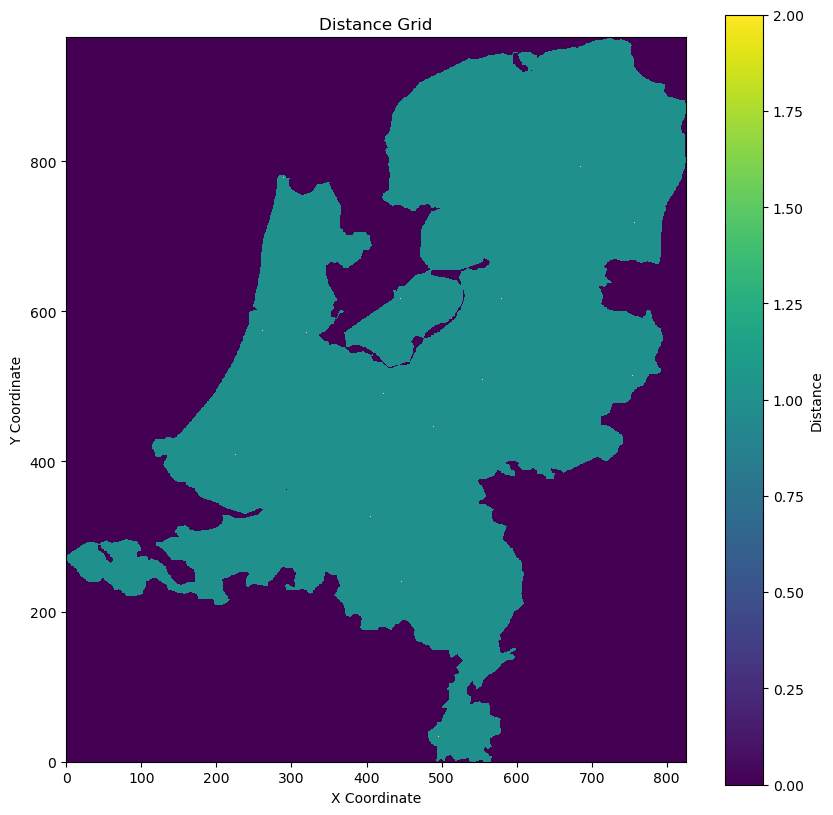

In [138]:
# Plot the grid using Matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(map_with_stations.T, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Distance')
plt.title('Distance Grid')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.ylim(0, map_with_stations.shape[1])  # Invert y-axis to match the original grid orientation
plt.show()

In [148]:
# --- Parameters ---
substrate_size = map_with_stations.shape
n_agents = 20
agent_speed = 1.5
fps = 60
n_frames = 60 * fps  # 60 seconds at 60 fps
force_c = 10.0
nuclei_sampling_rate = 1
n_station = 10
stations = jnp.where(map_with_stations == 2)
stations = jnp.array(stations).T
total_agents = len(stations) * n_agents
depletion_threshold = n_agents // 5

In [149]:
# --- Precompute Perlin noise for all agents and timesteps ---
n_frames_noise = jnp.round(1.5*n_frames).astype(jnp.int32)
noise_array = jnp.zeros((n_frames, total_agents, 2))

# generate offset for each agent and dimension
offsets = jax.random.uniform(random.PRNGKey(0), (total_agents, 2), minval=0, maxval=0.5)
offsets = jnp.round(offsets * n_frames).astype(jnp.int32)

for agent in range(total_agents):
    # Generate noise for each agent, with random_start for decorrelation
    p_x = Perlin(seed=agent + 1)
    noise_x_full = jnp.array([perlin_multi_octave(p_x, t / fps + p_x.lowerBound, octaves=4, persistence=0.5, lacunarity=2.0) for t in range(n_frames_noise)])
    p_y = Perlin(seed=2*(agent + 1))
    noise_y_full = jnp.array([perlin_multi_octave(p_y, t / fps + p_y.lowerBound, octaves=4, persistence=0.5, lacunarity=2.0) for t in range(n_frames_noise)])
    # Apply the offset for this agent and dimension
    start_x = int(offsets[agent, 0])
    start_y = int(offsets[agent, 1])
    noise_x = noise_x_full[start_x:start_x + n_frames]
    noise_y = noise_y_full[start_y:start_y + n_frames]

    noise = jnp.stack((noise_x, noise_y), axis=-1)
    noise_array = noise_array.at[:, agent].set(noise)

# set the range of the noise values to be between -1 and 1
noise_array = (noise_array - jnp.min(noise_array)) / (jnp.max(noise_array) - jnp.min(noise_array)) * 2 - 1

In [150]:
# --- Outer simulation loop in Python ---
# set the positions to the middle of the grid
middle_x = map_with_stations.shape[1]//2
middle_y = map_with_stations.shape[0]//2
positions = [jnp.ones((n_agents, 2)) * jnp.array([middle_x,middle_y])]
station_status = jnp.ones(len(stations)) # 1 means active, 0 means depleted
station_count = jnp.zeros(len(stations)) # count of agents at each station
all_trails = jnp.zeros((n_frames, total_agents, 2))

for t in range(n_frames):
    # Stack all current agent positions
    pos = jnp.vstack(positions)
    n_current_agents = pos.shape[0]

    # Compute deterministic force from the closest active station source for each agent
    vectors = stations[None, :, :] - pos[:, None, :]  # (n_agents, n_stations, 2)
    dists = jnp.linalg.norm(vectors, axis=-1) + 1e-6      # (n_agents, n_stations)
    # Mask out inactive station sources by setting their distance to a large value
    masked_dists = dists + (1.0 - station_status[None, :]) * 1e9
    closest_idx = jnp.argmin(masked_dists, axis=1) # (n_agents,)

    # Gather the vector and distance to the closest station source for each agent
    closest_vectors = vectors[jnp.arange(pos.shape[0]), closest_idx]  # (n_agents, 2)
    closest_dists = masked_dists[jnp.arange(pos.shape[0]), closest_idx]  # (n_agents,)

    min_dist = 1.0  # Prevent division by very small distances
    safe_dists = jnp.maximum(closest_dists, min_dist)
    force_mag = jnp.sqrt(force_c / safe_dists)
    force_dir = closest_vectors / safe_dists[..., None]
    deterministic = force_dir * force_mag[..., None]  # (n_agents, 2)
    
    # Stochastic force
    stochastic = noise_array[t, :n_current_agents]
    move_vec = deterministic + stochastic
    move_vec /= jnp.linalg.norm(move_vec, axis=1, keepdims=True) + 1e-6  # Normalize to unit length
    # Scale by agent speed
    move_vec = move_vec * agent_speed 
    # Check if the new position is allowed (map_with_stations !=0) 
    new_pos = pos + move_vec
    allowed = map_with_stations[
    new_pos[:, 0].astype(jnp.int32), 
    new_pos[:, 1].astype(jnp.int32)
    ] != 0
    new_pos = jnp.where(allowed[:, None], new_pos, pos)

    # Check for agents
    reached = jnp.linalg.norm(new_pos[:, None, :] - stations[None, :, :], axis=-1) < 5.0
    station_counts = jnp.sum(reached, axis=0)
    # Find which station sources are newly depleted this step
    newly_depleted = (station_status == 1) & (station_counts >= depletion_threshold)
    station_status = station_status * (station_counts < depletion_threshold)

    # For each newly depleted station source, spawn n_agents at its location
    for i, depleted in enumerate(newly_depleted):
        if depleted:
            print(f"station source {i} depleted at timestep {t//60}.")
            spawn = jnp.tile(stations[i], (n_agents, 1)).astype(jnp.float32)
            positions.append(spawn)

    # Save trail for plotting
    if t % (nuclei_sampling_rate) == 0:
        all_trails = all_trails.at[t, :n_current_agents].set(pos[:n_current_agents])

    # Update positions for next step
    positions[:n_current_agents] = new_pos

    # Stop if all station sources are depleted
    if jnp.all(station_status == 0):
        print(f"All station sources depleted. Stop at timestep {t//60}.")
        # get rid of the positions that are zero,zero in all_trails
        all_trails = all_trails[:t]
        all_trails = all_trails[~jnp.all(all_trails == 0, axis=(1, 2))]
        break
    elif t == n_frames - 1:
        print(f"Reached max timesteps. Stop at timestep {t//60}.")
        # get rid of the positions that are zero,zero in all_trails
        all_trails = all_trails[:t]
        all_trails = all_trails[~jnp.all(all_trails == 0, axis=(1, 2))]
        break

station source 19 depleted at timestep 0.
station source 23 depleted at timestep 0.
station source 22 depleted at timestep 1.
station source 24 depleted at timestep 1.
station source 27 depleted at timestep 2.
station source 16 depleted at timestep 3.
station source 26 depleted at timestep 3.
station source 15 depleted at timestep 3.
station source 13 depleted at timestep 3.
station source 12 depleted at timestep 4.
station source 31 depleted at timestep 4.
station source 18 depleted at timestep 4.
station source 30 depleted at timestep 4.
station source 6 depleted at timestep 5.
station source 32 depleted at timestep 5.
station source 3 depleted at timestep 5.
station source 9 depleted at timestep 6.
station source 5 depleted at timestep 6.
station source 2 depleted at timestep 6.
station source 10 depleted at timestep 6.
station source 4 depleted at timestep 7.
station source 17 depleted at timestep 7.
station source 1 depleted at timestep 7.
station source 14 depleted at timestep 7.

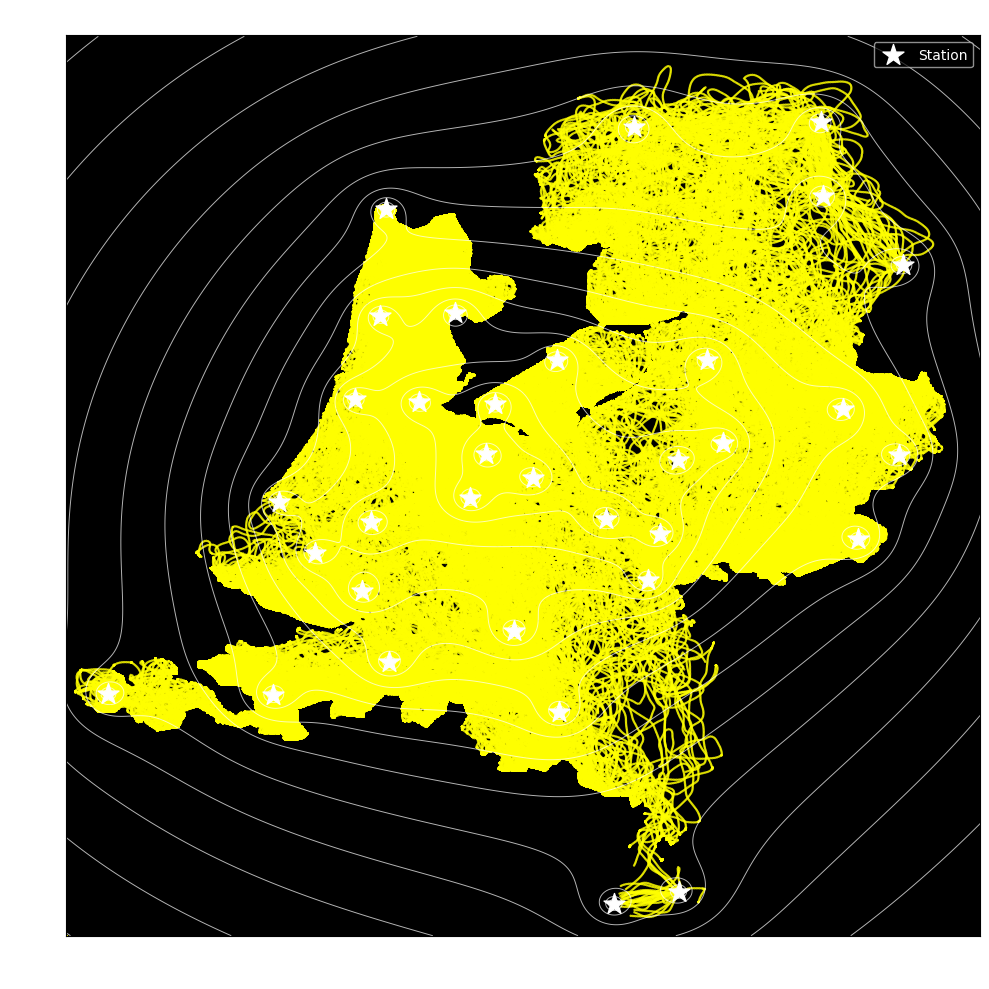

In [151]:
# --- Improved Plot: Slime Mold Foraging Simulation ---
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_facecolor('black')

# Attractive field as filled contours (viridis) and white contour lines
x, y = np.meshgrid(np.arange(map_with_stations.shape[1]), np.arange(map_with_stations.shape[1]))
attractiveness = np.zeros((map_with_stations.shape[1], map_with_stations.shape[1]))
for i in range(len(stations)):
    vectors = stations[i] - np.dstack((x, y))
    dists = np.linalg.norm(vectors, axis=-1) + 1e-6
    attractiveness += np.sqrt(force_c / dists)

# Specify contour levels explicitly
levels=np.linspace(0, 15, 50)
# cf = ax.contourf(x, y, attractiveness, levels=levels, cmap='viridis', alpha=0.5)
cl = ax.contour(x, y, attractiveness, levels=levels, colors='white', linewidths=0.7, alpha=0.7)

# Plot agent trails
ax.scatter(all_trails[:, :, 0].flatten(), all_trails[:, :, 1].flatten(), c='yellow', alpha=0.8, s=3, edgecolors='none')

# Plot station sources as white stars with red edge
ax.scatter(stations[:, 0], stations[:, 1], c='white', marker='*', s=250, label='Station')

# Axis and legend
ax.set_xlim(0, map_with_stations.shape[0])
ax.set_ylim(0, map_with_stations.shape[1])
ax.set_title('Slime Mold Foraging Simulation', color='white', fontsize=16)
ax.set_xlabel('X Position', color='white')
ax.set_ylabel('Y Position', color='white')
ax.tick_params(colors='white')
legend = ax.legend(facecolor='black', framealpha=0.7, loc='upper right')
for text in legend.get_texts():
    text.set_color('white')

plt.tight_layout()
plt.show()

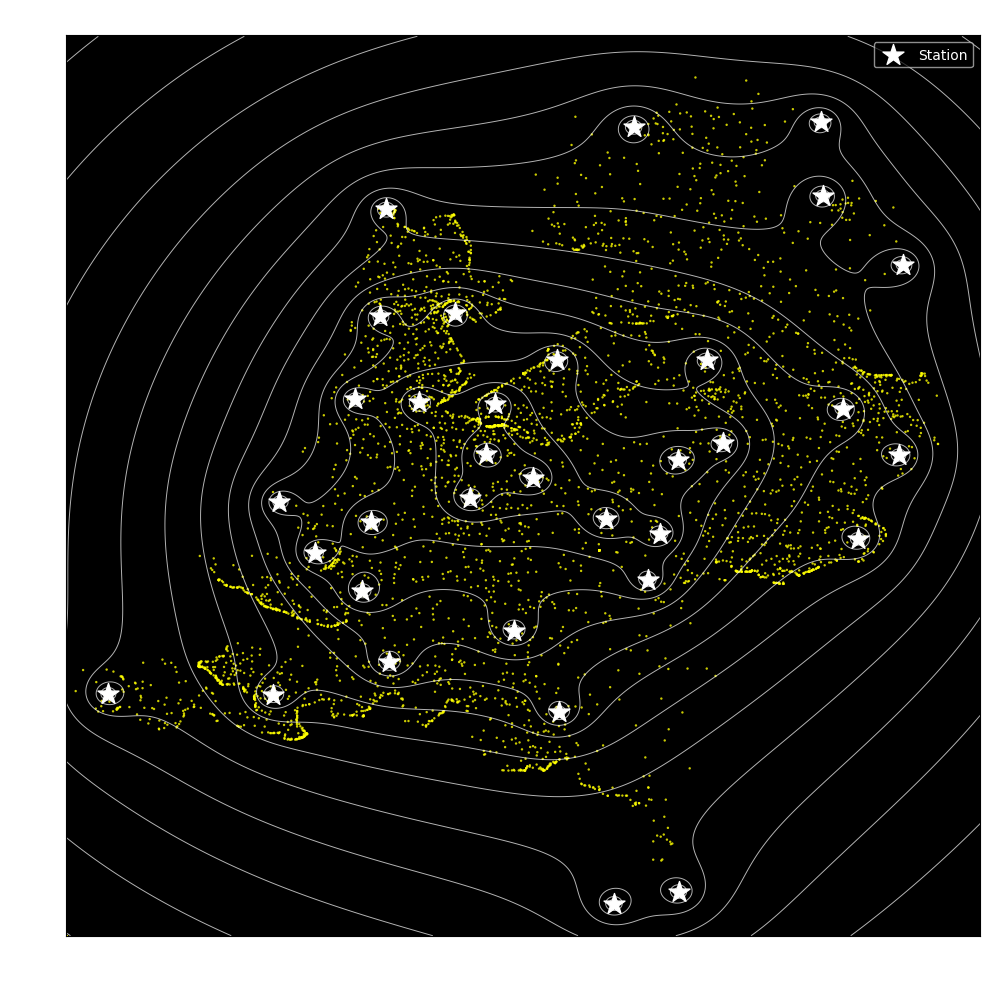

In [167]:
# --- Improved Plot: Slime Mold Foraging Simulation ---
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_facecolor('black')

# resample the trails with a new nuclei_sampling_rate
nuclei_sampling_rate = 3 * fps
nuclei = all_trails[::nuclei_sampling_rate]

# cf = ax.contourf(x, y, attractiveness, levels=levels, cmap='viridis', alpha=0.5)
cl = ax.contour(x, y, attractiveness, levels=levels, colors='white', linewidths=0.7, alpha=0.7)

# Plot agent trails
ax.scatter(nuclei[:, :, 0].flatten(), nuclei[:, :, 1].flatten(), c='yellow', alpha=0.8, s=3, edgecolors='none')

# Plot station sources as white stars with red edge
ax.scatter(stations[:, 0], stations[:, 1], c='white', marker='*', s=250, label='Station')

# Axis and legend
ax.set_xlim(0, map_with_stations.shape[0])
ax.set_ylim(0, map_with_stations.shape[1])
ax.set_title('Slime Mold Foraging Simulation', color='white', fontsize=16)
ax.set_xlabel('X Position', color='white')
ax.set_ylabel('Y Position', color='white')
ax.tick_params(colors='white')
legend = ax.legend(facecolor='black', framealpha=0.7, loc='upper right')
for text in legend.get_texts():
    text.set_color('white')

plt.tight_layout()
plt.show()

In [168]:
# 1. Gather all points: nuclei trail points + stations
# Flatten all_trails and remove zero rows (unused slots)
points = nuclei.reshape(-1, 2)
points = points[~np.all(points == 0, axis=1)]  # Remove zero points

# Add stations (convert to numpy if needed)
station_points = np.array(stations)
all_points = np.vstack([points, station_points])

# 2. Build KDTree for fast neighbor search
tree = cKDTree(all_points)

# 3. For each point, find its pm=10 nearest neighbors (excluding itself)
pm = 10
dists, idxs = tree.query(all_points, k=pm+1)  # +1 because first neighbor is itself

# 4. Build the proximity graph
G = nx.Graph()

# idxs: shape (N, pm+1), where idxs[i, 0] == i (self), idxs[i, 1:] are neighbors
src = np.repeat(np.arange(idxs.shape[0]), idxs.shape[1] - 1)
dst = idxs[:, 1:].reshape(-1) 
edges = np.stack([src, dst], axis=1) # shape (N*(pm-1), 2)

# Compute edge weights (Euclidean distances)
diffs = all_points[edges[:, 0]] - all_points[edges[:, 1]]
weights = np.linalg.norm(diffs, axis=1)

# Add all edges at once to the graph
G.add_weighted_edges_from([(int(i), int(j), float(w)) for (i, j), w in zip(edges, weights)])

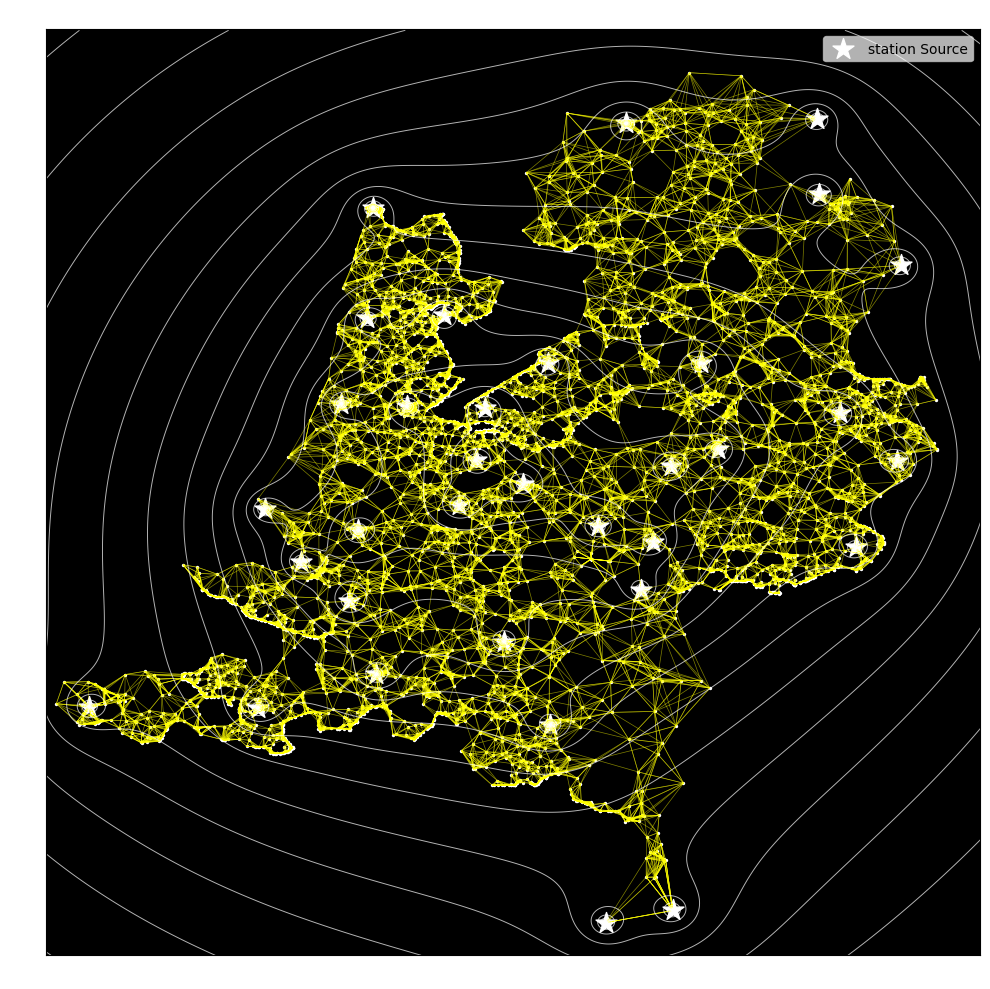

In [169]:
from matplotlib.collections import LineCollection

# Prepare edge segments for LineCollection
edge_segments = np.stack([
    np.stack([all_points[edges[:, 0]], all_points[edges[:, 1]]], axis=1)
], axis=0).reshape(-1, 2, 2)

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_facecolor('black')

# Draw all edges at once
lc = LineCollection(edge_segments, colors='yellow', linewidths=0.5, alpha=0.5)
ax.add_collection(lc)

cl = ax.contour(x, y, attractiveness, levels=levels, colors='white', linewidths=0.7, alpha=0.7)

# Draw points
ax.scatter(points[:, 0], points[:, 1], c='white', s=2)
ax.scatter(station_points[:, 0], station_points[:, 1], c='white', marker='*', s=250, label='station Source')

ax.set_xlim(0, map_with_stations.shape[0])
ax.set_ylim(0, map_with_stations.shape[1])
ax.set_title('10-Nearest Neighbor Proximity Mesh', color='white')
ax.legend(facecolor='white', framealpha=0.7, loc='upper right')
ax.tick_params(colors='white')
plt.tight_layout()
plt.savefig('slime_mold_proximity_mesh.png', dpi=300)
plt.show()

In [170]:
from scipy.spatial import distance_matrix
from itertools import combinations

# --- Proximity coefficient ---
p = 3 # Set this to your desired number of closest neighbors

# Indices of station sources in all_points (they are last in the array)
station_indices = np.arange(all_points.shape[0] - len(station_points), all_points.shape[0])

# Compute pairwise distances between station sources
station_coords = all_points[station_indices]
station_dmat = distance_matrix(station_coords, station_coords)

# For each station source, get indices of its p closest station source neighbors (excluding self)
np.fill_diagonal(station_dmat, np.inf)
closest_neighbors = np.argsort(station_dmat, axis=1)[:, :p]

# Build set of unique station source pairs to connect (undirected)
station_pairs = set()
for i, nbrs in enumerate(closest_neighbors):
    for j in nbrs:
        # Convert local indices to global indices in all_points
        a, b = station_indices[i], station_indices[j]
        station_pairs.add(tuple(sorted((a, b))))

# --- Build refined network using only mesh edges ---
edge_set = set()
for a, b in station_pairs:
    try:
        path = nx.shortest_path(G, source=a, target=b, weight='weight')
        edge_set.update((min(path[k], path[k+1]), max(path[k], path[k+1])) for k in range(len(path)-1))
    except nx.NetworkXNoPath:
        continue

# Convert edge_set to array for vectorized plotting
refined_edges = np.array(list(edge_set))
refined_segments = np.stack([all_points[refined_edges[:, 0]], all_points[refined_edges[:, 1]]], axis=1)

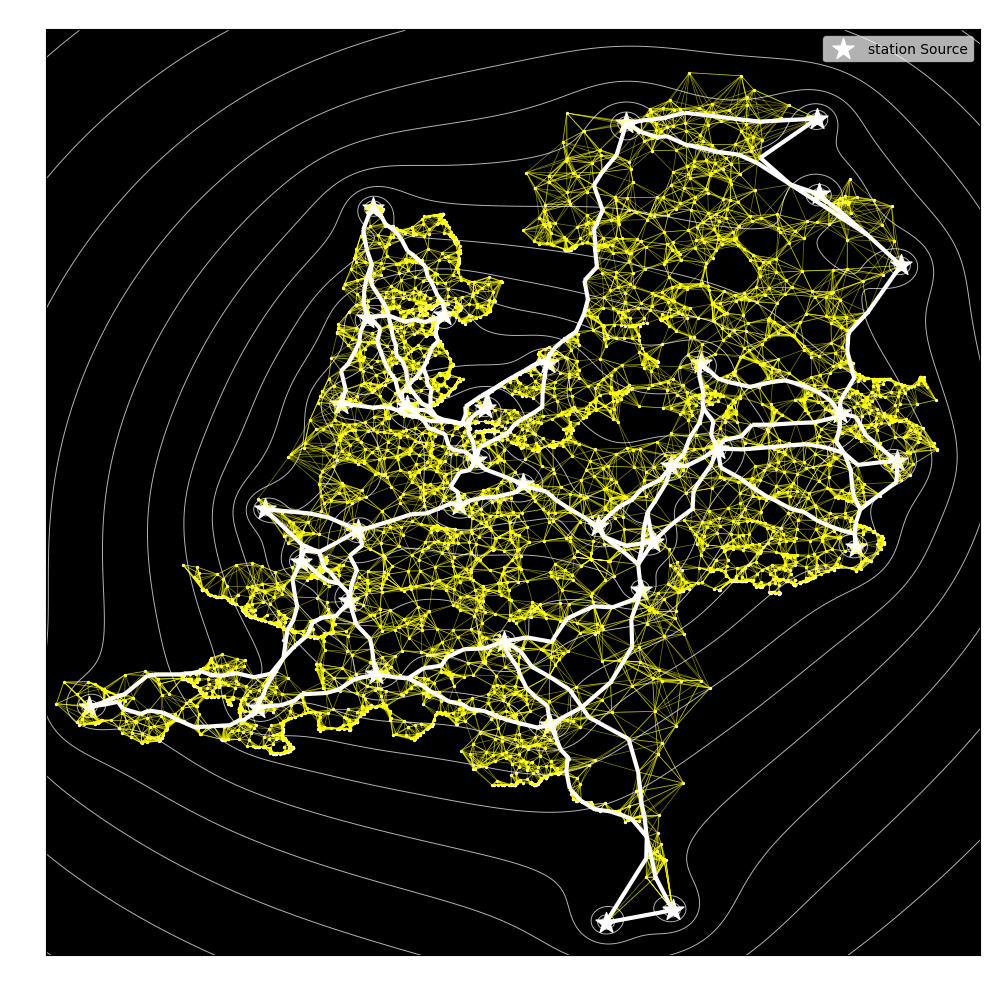

In [171]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_facecolor('black')

# Optionally, overlay the mesh in the background (faint)
lc_mesh = LineCollection(edge_segments, colors='yellow', linewidth=0.5, alpha=0.5)
ax.add_collection(lc_mesh)

# Draw refined network edges
lc = LineCollection(refined_segments, colors='white', linewidths=3)
ax.add_collection(lc)

cl = ax.contour(x, y, attractiveness, levels=levels, colors='white', linewidths=0.7, alpha=0.7)

# Draw points
ax.scatter(points[:, 0], points[:, 1], c='white', s=2)
ax.scatter(station_points[:, 0], station_points[:, 1], c='white', marker='*', s=250, label='station Source')

ax.set_xlim(0, map_with_stations.shape[0])
ax.set_ylim(0, map_with_stations.shape[1])
ax.set_title('Refined Shortest-Walk Network (Stage 2)', color='white')
ax.legend(facecolor='white', framealpha=0.7, loc='upper right')
ax.tick_params(colors='white')
plt.tight_layout()
plt.savefig('slime_mold_refined_network.png', dpi=300)
plt.show()

In [ ]:
from tqdm import tqdm

# Create a function for calculating the cost of the refined network () = sum of edge weights while ignoring overlapping edges
def calculate_network_cost(G, edges):
    total_cost = 0.0
    for edge in edges:
        if G.has_edge(edge[0], edge[1]):
            total_cost += G[edge[0]][edge[1]]['weight']
    return total_cost

# Calculate the cost of the refined network
refined_cost = calculate_network_cost(G, refined_edges)
print(f"Total cost of the refined network: {refined_cost:.2f}")

# Create a function for calculating the network mean travel time = mean distance between all pairs of station sources over the refined network
def calculate_mean_travel_time(G, station_indices):
    total_time = 0.0
    count = 0
    for i in range(len(station_indices)):
        for j in range(i + 1, len(station_indices)):
            try:
                path_length = nx.shortest_path_length(G, source=station_indices[i], target=station_indices[j], weight='weight')
                total_time += path_length
                count += 1
            except nx.NetworkXNoPath:
                # If no path exists add the sum of all edges
                total_time += sum(G[edge[0]][edge[1]]['weight'] for edge in G.edges if edge[0] in station_indices and edge[1] in station_indices)
                count += 1
                print(f"No path between station sources {station_indices[i]} and {station_indices[j]}. Using sum of all edges.")
    return total_time / count

# Calculate the mean travel time of the refined network
# mean_travel_time = calculate_mean_travel_time(G, station_indices)
mean_travel_time = calculate_mean_travel_time(G, station_indices)
print(f"Mean travel time of the refined network: {mean_travel_time:.2f}")

# Create a function for network vulnerability = mean travel time of the refined network with the connection between two station sources removed
def calculate_network_vulnerability(G, station_indices):
    vulnerabilities = []
    for i in tqdm(range(len(station_indices))):
        for j in range(i + 1, len(station_indices)):
            # Create a copy of the graph to avoid modifying the original
            G_copy = G.copy()
            # Remove the path (of multiple edges) between the two station sources
            # Check if the edge exists before trying to remove it
            # If the edge exists, remove it
            try:
                path = nx.shortest_path(G_copy, source=station_indices[i], target=station_indices[j], weight='weight')
                for k in range(len(path) - 1):
                    G_copy.remove_edge(path[k], path[k + 1])
            except nx.NetworkXNoPath:
                print(f"No path between station sources {station_indices[i]} and {station_indices[j]}. Skipping.")
                continue
            # Calculate the mean travel time of the modified network
            mean_time = calculate_mean_travel_time(G_copy, station_indices)
            vulnerabilities.append(mean_time)
    return np.mean(vulnerabilities)

# Calculate the network vulnerability
network_vulnerability = calculate_network_vulnerability(G, station_indices)
print(f"Network vulnerability (mean travel time with one connection removed): {network_vulnerability:.2f}")

Total cost of the refined network: 7065.42


TypeError: average_shortest_path_length() got an unexpected keyword argument 'source'

In [177]:
G